In [1]:
from datasets import load_dataset

/Users/liamoreilly/Desktop/CornellTech/AI-detection/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

### Preprocessing

In [3]:
dataset = load_dataset("Hello-SimpleAI/HC3", name='all')
dataset = dataset['train'].to_pandas()

In [4]:
len(dataset)

24322

In [5]:
reduced_df = dataset.head(500).drop(columns=['source'])

human_df = reduced_df[['human_answers']].rename(columns={'human_answers':'text'})
human_df['prompt_id'] = reduced_df["id"]
human_df['text'] = human_df['text'].apply(lambda x: ''.join(x))
human_df['label'] = 0

llm_df = reduced_df[['chatgpt_answers']].rename(columns={'chatgpt_answers':'text'})
llm_df['prompt_id'] = reduced_df["id"]
llm_df['text'] = llm_df['text'].apply(lambda x: ''.join(x))
llm_df['label'] = 1

full_df = pd.concat((human_df, llm_df), axis=0, ignore_index=True)
full_df = full_df[['text', 'label']]

In [6]:
df = full_df.sample(frac=1).reset_index(drop=True)
df.head(5)

,text,label
0,The US government gives farmers money to grow ...,0
1,By matching its speed . Ever see a movie where...,0
2,The juices on the shelf are long - life and do...,0
3,"It is not safe to use any illegal drugs, inclu...",1
4,The Constitution is the highest law of the lan...,0


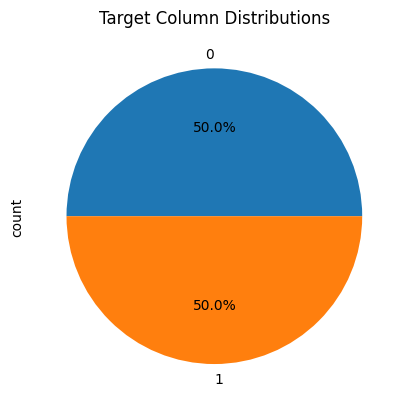

In [7]:
full_df.label.value_counts().plot(kind='pie',autopct="%.1f%%")
plt.title("Target Column Distributions")
plt.show()

### Bert

In [8]:
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
import torch
from datasets import Dataset

In [10]:
# Split the data
train_texts, val_texts, train_labels, val_labels = train_test_split(
    df['text'].tolist(), df['label'].tolist(), test_size=0.2, random_state=42
)

In [11]:
# Tokenization
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
train_encodings = tokenizer(train_texts, truncation=True, padding=True, max_length=512)
val_encodings = tokenizer(val_texts, truncation=True, padding=True, max_length=512)

In [12]:

# Create datasets
train_dataset = Dataset.from_dict({'input_ids': train_encodings['input_ids'], 
                                   'attention_mask': train_encodings['attention_mask'], 
                                   'labels': train_labels})
val_dataset = Dataset.from_dict({'input_ids': val_encodings['input_ids'], 
                                 'attention_mask': val_encodings['attention_mask'], 
                                 'labels': val_labels})

In [13]:
# Define the model
model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=2)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [14]:
# Training arguments
training_args = TrainingArguments(
    output_dir="./results",
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=5e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=3,
    weight_decay=0.01,
    logging_dir="./logs",
    logging_steps=10,
    load_best_model_at_end=True
)

# Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
)

In [15]:
# Fine-tune the model
trainer.train()

  0%|          | 1/300 [02:06<10:32:15, 126.87s/it]

KeyboardInterrupt: 

In [ ]:

# Evaluate
trainer.evaluate()

# Save the model
model.save_pretrained("./bert-ai-detection")
tokenizer.save_pretrained("./bert-ai-detection")
